In [ ]:
## Importing Packages
!pip install pycountry

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry as pc

pd.options.display.max_columns = None

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## Importing Data
from google.colab import files
uploaded = files.upload()
data = pd.read_csv('hotel_bookings.csv')

Saving hotel_bookings.csv to hotel_bookings.csv


In [ ]:
## Showing the first 5 rows of Data
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


<hr>

In [ ]:
## Data Preprocessing
## Copy the dataset
df = data.copy()

In [ ]:
## Find the missing value
df.isnull().sum().sort_values(ascending=False)[:10]

company                   112593
agent                      16340
country                      488
children                       4
reserved_room_type             0
assigned_room_type             0
booking_changes                0
deposit_type                   0
hotel                          0
previous_cancellations         0
dtype: int64

In [ ]:
## Drop Rows where there is no adult, baby and child
df = df.drop(df[(df.adults+df.babies+df.children)==0].index)


## If no id of agent or company is null, just replace it with 0
df[['agent','company']] = df[['agent','company']].fillna(0.0)


## For the missing values in the country column, replace it with mode (value that appears most often)
df['country'].fillna(data.country.mode().to_string(), inplace=True)


## for missing children value, replace it with rounded mean value
df['children'].fillna(round(data.children.mean()), inplace=True)

In [ ]:
## convert datatype of these columns from float to integer
df[['children', 'company', 'agent']] = df[['children', 'company', 'agent']].astype('int64')

In [ ]:
 
def plot(x, y, x_label='', y_label='', title='', figsize=(8,6), type='bar'):
  plt.figure(figsize=figsize)
  ax = plt.gca()
  if x_label:
    ax.set_xlabel(x_label)
  if y_label:
    ax.set_ylabel(y_label)
  if title:
    ax.set_title(title)
  if type == 'bar':
    sns.barplot(x=x, y=y, ax=ax)
  elif type == 'line':
    sns.lineplot(x=x, y=y, ax=ax)
  else:
    raise ValueError("Invalid plot type")
  plt.show()

In [ ]:
def get_count(series, limit=None):
    
    '''
    INPUT:
        series: Pandas Series (Single Column from DataFrame)
        limit:  If value given, limit the output value to first limit samples.
    OUTPUT:
        x = Unique values
        y = Count of unique values
    '''
    
    if limit != None:
        series = series.value_counts()[:limit]
    else:
        series = series.value_counts()
    
    x = series.index
    y = series/series.sum()*100
    
    return x.values,y.values

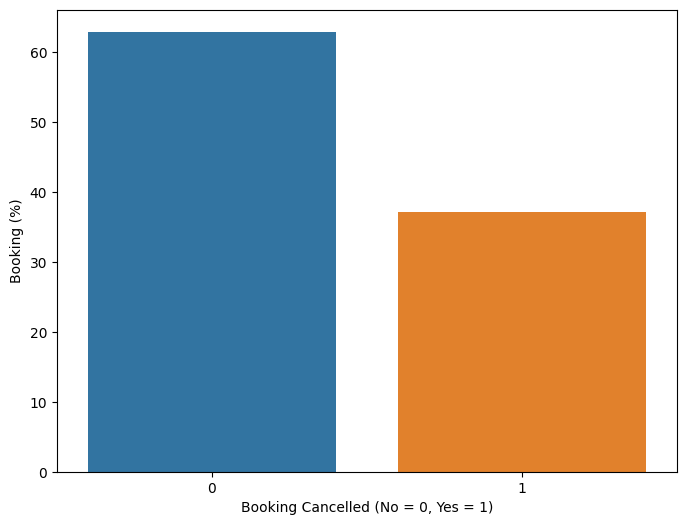

In [ ]:
## How many bookings were cancelled
x,y = get_count(df['is_canceled'])
plot(x,y, x_label='Booking Cancelled (No = 0, Yes = 1)', y_label='Booking (%)', type='bar')


In [ ]:
df_not_canceled = df[df['is_canceled'] == 0]

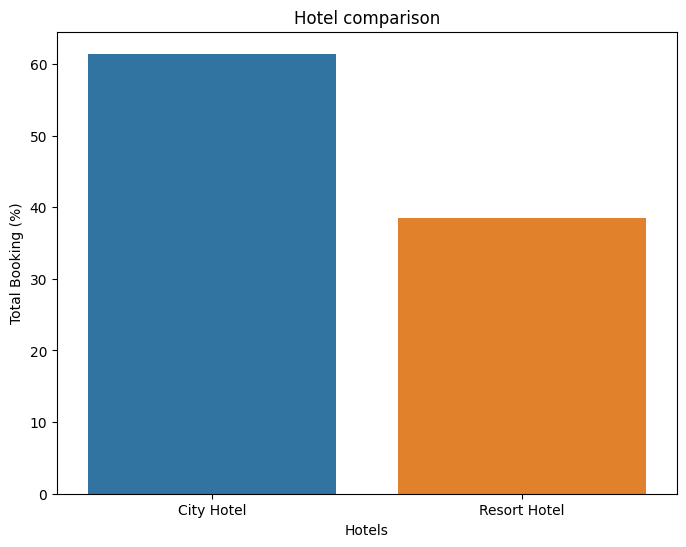

In [ ]:
## booking ratio between resort hotel and the city hotel
x,y = get_count(df_not_canceled['hotel'])
plot(x,y, x_label='Hotels', y_label='Total Booking (%)', title='Hotel comparison')

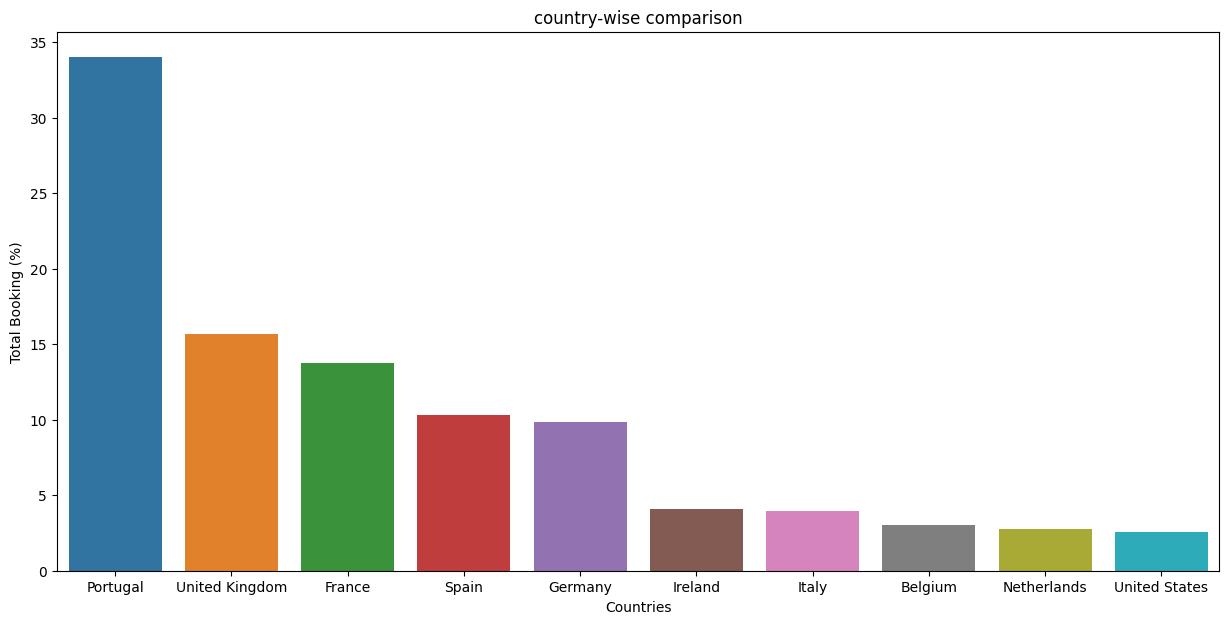

In [ ]:
## from which country most guests come
import pycountry as pc

x,y = get_count(df_not_canceled['country'], limit=10)

## For each country code select the country name 
country_name = [pc.countries.get(alpha_3=name).name for name in x]

plot(country_name,y, x_label='Countries', y_label='Total Booking (%)', title='country-wise comparison', figsize=(15,7))

In [ ]:
## Feature selection and engineering
## Copy the dataframe
df_subset = df.copy()

In [ ]:
## Remove reservation_status column
## because it tells us if booking was cancelled 
df_subset = df_subset.drop(['reservation_status'], axis=1)

In [ ]:
## Make the new column which contain 1 if guest received the same room which was reserved otherwise 0
df_subset['Room'] = 0
df_subset.loc[ df_subset['reserved_room_type'] == df_subset['assigned_room_type'] , 'Room'] = 1


## Make the new column which contain 1 if the guest has cancelled more booking in the past
## than the number of booking he did not cancel, otherwise 0

df_subset['net_cancelled'] = 0
df_subset.loc[ df_subset['previous_cancellations'] > df_subset['previous_bookings_not_canceled'] , 'net_cancelled'] = 1

In [ ]:
## Remove the less important features
df_subset = df_subset.drop(['arrival_date_year','arrival_date_week_number','arrival_date_day_of_month','arrival_date_month','assigned_room_type','reserved_room_type','reservation_status_date','previous_cancellations','previous_bookings_not_canceled'],axis=1)

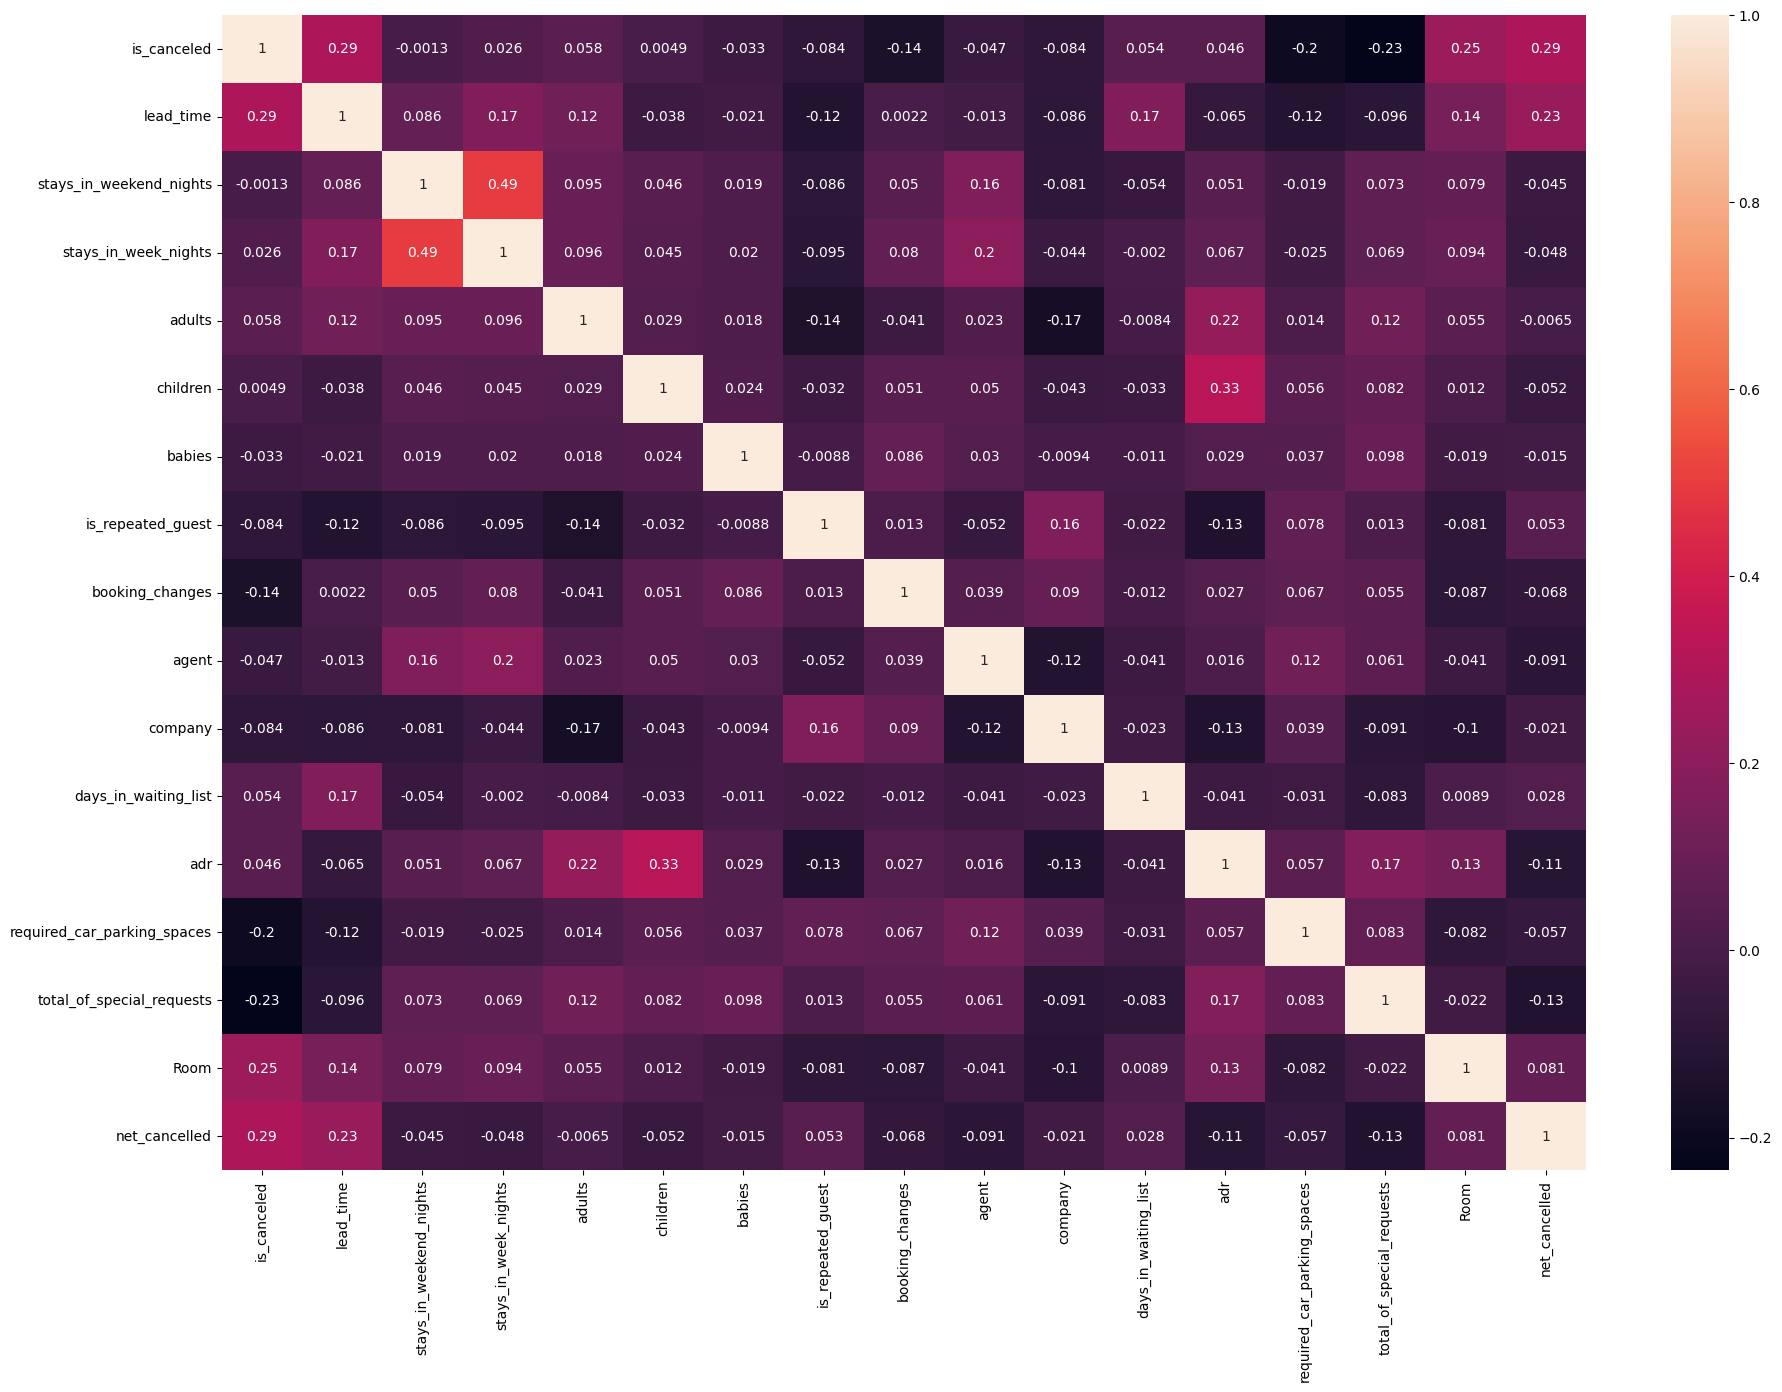

In [ ]:
## Plot the heatmap to see correlation with columns
fig, ax = plt.subplots(figsize=(22,15))
sns.heatmap(df_subset.corr(), annot=True, ax=ax);

In [ ]:
# Perform data preprocessing on the DataFrame
# Example: Extract two groups of data based on a categorical column
group1_data = df[df['hotel'] == 'Resort Hotel']['previous_cancellations']
group2_data = df[df['hotel'] == 'City Hotel']['previous_bookings_not_canceled']


In [ ]:
# Check data types of extracted columns
print(group1_data.dtypes)
print(group2_data.dtypes)


int64
int64


In [ ]:
# Convert columns to numeric type
group1_data = pd.to_numeric(group1_data, errors='coerce')
group2_data = pd.to_numeric(group2_data, errors='coerce')

# Drop rows with missing values
group1_data = group1_data.dropna()
group2_data = group2_data.dropna()


In [ ]:
## t-test
from scipy.stats import ttest_ind

# Perform t-test on the extracted groups of data
t_statistic, p_value = ttest_ind(group1_data, group2_data, equal_var=False)

# Print results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Define significance level
alpha = 0.05

# Check for statistical significance
if p_value < alpha:
    print("Reject null hypothesis. There is a statistically significant difference between the two groups based on the attribute.")
else:
    print("Fail to reject null hypothesis. There is no statistically significant difference between the two groups based on the attribute.")


T-statistic: -3.4018430874330403
P-value: 0.000669595825894014
Reject null hypothesis. There is a statistically significant difference between the two groups based on the attribute.


In [ ]:
## Modelling
## Converting Categorical variables to numerical
def transform(dataframe):
    
    
    ## Import LabelEncoder from sklearn
    from sklearn.preprocessing import LabelEncoder
    
    le = LabelEncoder()
    
    
    ## Select all categorcial features
    categorical_features = list(dataframe.columns[dataframe.dtypes == object])
    
    
    ## Apply Label Encoding on all categorical features
    return dataframe[categorical_features].apply(lambda x: le.fit_transform(x))

df = transform(df)

In [ ]:
def data_split(df, label):
    
    from sklearn.model_selection import train_test_split

    X = df.drop(label, axis=1)
    Y = df[label]

    x_train, x_test, y_train, y_test = train_test_split(X,Y,random_state=0)
    
    return x_train, x_test, y_train, y_test



x_train, x_test, y_train, y_test = data_split(df_subset, 'is_canceled')

In [ ]:
# one-hot encode the 'hotel' column
x_train = pd.get_dummies(x_train, columns=['hotel','meal','country','market_segment','distribution_channel','deposit_type','agent','company','customer_type'])


In [ ]:
def train(x_train, y_train):
    from sklearn.tree import DecisionTreeClassifier

    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(x_train,y_train)
    
    return clf


clf = train(x_train, y_train)




In [ ]:
def Score(clf,x_train,y_train,x_test,y_test):
    train_score = clf.score(x_train,y_train)
    test_score = clf.score(x_test,y_test)

    print("========================================")
    print(f'Training Accuracy of our model is: {train_score}')
    print(f'Test Accuracy of our model is: {test_score}')
    print("========================================")
    
    
Score(clf,x_train,y_train,x_train,y_train)

Training Accuracy of our model is: 0.9956043710224032
Test Accuracy of our model is: 0.9956043710224032


---------------